# Computer Vision - Assignment 3 - Feature Extraction and Image Stitching

#### 10 points   |   Due date: December 31, 23:59   |   Submission site: https://pradogrado2324.ugr.es/

### Student's Full Name: <mark>Javier Moreno Morón</mark>



<font color='blue'>In this assignment you will learn:

<font color='blue'>a) to detect interest points using the Harris Corner Detector (Exercise 2) and a multi-scale approach to detect blobs using the Laplacian of Gaussian (Exercise 1).

<font color='blue'>b) to find correspondences between the keypoints from two images using descriptors (SIFT and Haralick) (Exercise 3).

<font color='blue'>c) to compose a rectangular mosaic/panorama from a bunch of images using homographies (Exercise 4).

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import sys,os
%cd '/content/drive/My Drive'
get_image = lambda route: os.path.join('/content/drive/MyDrive/images/', route)
import numpy as np
from matplotlib import pyplot as plt
import cv2

Mounted at /content/drive
/content/drive/My Drive


In [2]:
'''
This function receives a string with the filename of the image to read,
and a flag indicating if we want to read it in color/RGB (flagColor=1) or gray level (flagColor=0)

Example of use:
im1=readIm(get_image('apple.jpg'),0)

'''
def readIm(filename, flagColor=1):
  # cv2 reads BGR format
  im=cv2.imread(filename)
  # change to  RGB and return the image
  if(flagColor):
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
  # change from BGR to grayscale instead if flag is 0
  return cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)

In [3]:
'''
This function receives an array of arbitrary real numbers (that could include even negative values),
and returns an 'image' in the range [0,1].
flag_GLOBAL allows the user to normalize the whole image (including all channels) or to normalize
each channel/band independently.
'''
def rangeDisplay01(im, flag_GLOBAL= True):
  im = im.astype(float)
  if flag_GLOBAL:
    im = (im - im.min())/(im.max() - im.min())
  else:
    # bands normalization
    for band in range(im.shape[2]):
      im[:, :, band] = (im[:, :, band] - im[:, :, band].min())/(im[:, :, band].max() - im[:, :, band].min())
      # Note: remember that, for plt.imshow with RGB data, the valid range is [0..1] for floats and [0..255] for integers.
  return im

In [4]:
'''
This function displays a single image, including a title, using a magnification factor.

Example of use:
im1=readIm(get_image('apple.jpg'),0)
displayIm(im1,'Manzana',0.5)

'''
def displayIm(im, title='Result',factor= 2):
  # First normalize range
  max=np.max(im)
  min=np.min(im)
  if min<0 or max>255:
    im=rangeDisplay01(im,flag_GLOBAL=True)
  if len(im.shape) == 3:
    # im es tribanda
    plt.imshow(im, cmap='jet')
  else:
    # im es monobanda
    plt.imshow(im, cmap='gray')
  figure_size = plt.gcf().get_size_inches()
  plt.gcf().set_size_inches(factor * figure_size)
  plt.title(title)
  plt.xticks([]), plt.yticks([]) # eliminamos numeración
  plt.show()

In [5]:
'''
This function displays multiple images (including a title and using a magnification factor)
of equal size. The input to the function is a list of images.

Example of use:
im1=readIm(get_image('apple.jpg'),1)
images = [im1,im1,im1]

displayMI_ES(images, title='Manzanas',factor=1)

'''
def displayMI_ES(vim, title='Result',factor=2):
  # We set the maximun number of images to concatenate by columns
  maxcolumns=3
  # number of images to display
  numberim=len(vim)
  # The simplest case, one row: the maximum number of columns is larger than the images to stack
  # This is, by default, we put together the images column-wise
  if len(vim) < maxcolumns:
    out=vim[0]
    for item in range(1,len(vim)):
      #displayIm(out,str(item),1)
      out=np.hstack((out,vim[item]))

  # Else, if maxcolumns is smaller or equal than the number of images to stack
  else:
    # We check if all rows and columns are going to be 'busy', or if otherwise we need an extra-row
    if np.mod(len(vim),maxcolumns)== 0:
      maxrows=numberim//maxcolumns
    else:
      maxrows=numberim//maxcolumns+1

    # we build up the first block-row
    out=vim[0]
    for item in range(1,maxcolumns):
      out=np.hstack((out,vim[item]))
    # We build up the rest of block-rows
    for block in range(1,maxrows):
      #print(block)
      row=vim[block*maxcolumns]
      for item in range(1,maxcolumns):
        # We still have images to stack
        if block*maxcolumns+item < numberim:
          row=np.hstack((row,vim[block*maxcolumns+item]))
        # We do not have more images, and we have to fill with black
        else:
          row=np.hstack((row,np.zeros(vim[0].shape,dtype=vim[0].dtype)))
          #print(row.dtype)
          # if we don't include ',dtype=vim[0].dtype', np.zeros will include float
          # numbers in the matrix. This will make that the whole matrix will be
          # considered as floats, and values larger than 1 will be clipped to 1,
          # displaying an almost totally white image
      # add the new block-row
      out=np.vstack((out,row))
  return displayIm(out,title,factor)

Incluimos primero las funciones para calcular la máscara gaussiana que creamos en la práctica 1, a cuya función final le podemos pasar por un lado el sigma o el tamaño de la máscara y luego el orden de la derivada de la gaussiana a usar para calcular la máscara.

In [6]:
# Here you include your functions from P1 to compute derivatives and convolution

def GaussFunc(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = np.exp(exponente)

    return resultado

def GaussDeriv1Func(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = (x * np.exp(exponente)) / (sigma ** 2)

    return - resultado

def GaussDeriv2Func(x,sigma):
    exponente = -(x ** 2) / (2 * sigma ** 2)
    resultado = (x-sigma) * (x+sigma) * np.exp(exponente)

    return resultado / (sigma ** 4)

def gaussianMask1D(sigma=0, sizeMask=0, order=0, verbose=False):
    # Calculamos sigma o sizeMask, según se especifique
    if(sigma == 0 and sizeMask == 0):
      raise ValueError("O sigma o sizeMask debe tener un valor")
    elif(sigma == 0):
      sigma = (sizeMask - 1) / 6
    elif(sizeMask == 0):
      sizeMask = 6 * sigma
      if(sizeMask % 2 == 0):
        sizeMask += 1
    else:
      raise ValueError("Solo sigma o sizeMask debe tener un valor, el otro debe valer 0")

    # Calculamos k
    k = (sizeMask - 1) / 2

    xvalues = np.arange(-k, k+1)

    # Calculamos la mascara dependiendo del orden elegido
    if(order == 0):
      mask = GaussFunc(xvalues, sigma)
      mask /= np.sum(mask) # Normalizamos la máscara
    elif(order == 1):
      mask = GaussDeriv1Func(xvalues, sigma)
      mask *= sigma # Escalamos la máscara
    else:
      mask = GaussDeriv2Func(xvalues, sigma)
      mask *= sigma**2 # Escalamos la máscara

    if(verbose):
      return mask, sigma, sizeMask, xvalues
    else:
      return mask


Y también creamos una función para calcular la laplaciana de las imágenes también usando código de la práctica 1.

In [7]:
def laplaciana2D(im, sigma):
  # Calculamos kernel 1D
  maskG=gaussianMask1D(sigma, order=0)
  mask2DG= gaussianMask1D(sigma, order=2)

  # Generamos las imágenes
  ddepth=cv2.CV_64F

  # Laplaciana de la Gaussiana
  G_x = cv2.sepFilter2D(im, ddepth, mask2DG, maskG)
  G_y = cv2.sepFilter2D(im, ddepth, maskG, mask2DG)

  Laplaciana = (G_x + G_y)

  return Laplaciana

# <font color='blue'>**Exercise 1:** Multi-scale blob detection using the Laplacian of Gaussian (2 points)

<font color='blue'> Students must implement a multiscale blob detector in Python that, based on successive applications of Laplacian of Gaussian (LoG) filters, allows them to identify interest points/regions. The process to follow is detailed below:

> <font color='blue'>1) use the following sigmas to create the corresponding scales: 11 values starting from $\sigma_0 = 0.5$ and increase $\sigma$ by a factor of 1.5. In other words, $\sigma=[0.5, 0.75, 1.125, 1.687, 2.531, 3.796, 5.695, 8.542, 12.814, 19.221, 28.832]$. Remember to convolve the image with scale-normalized LoG.

> <font color='blue'>2) Find maxima of squared Laplacian response in scale-space. Select the local maximum corresponding to a neighborhood $3\times3\times3$, where the central pixel of this volume would be the position to evaluate. That is, each pixel is compared with its 26 neighbors and saved if it is a maximum. The function `maximum_filter` from `scipy.ndimage` may be useful here. Along with this, also use a $\textit{threshold}$ to limit the number of blobs detected to around 1000 points.

> <font color='blue'>3) Draw the detected blobs as circles centered on the identified Cartesian coordinates, and radius proportional to the scale at which the corresponding blob was detected.

<font color='blue'>The process is visually shown on slide 63 of https://pradogrado2324.ugr.es/pluginfile.php/234073/mod_folder/content/0/3.3.BoW_Blobs.pdf

El porqué usar la Laplaciana de la Gaussiana para detectar blobs y usar distintas escalas es el siguiente:
* Detección de Blobs: Un "blob" se refiere a regiones distintivas o manchas en una imagen que pueden tener características como intensidades de píxeles significativamente diferentes en comparación con su entorno.

* Laplaciano de la Gaussiana (LoG): El Laplaciano es un operador diferencial que mide la magnitud de la segunda derivada espacial de una función. En el contexto de imágenes, se utiliza para resaltar áreas donde la intensidad cambia rápidamente.

* Multi-Scale Blob Detection: Las características en una imagen pueden tener diferentes tamaños o escalas. La detección a múltiples escalas implica analizar la imagen en diferentes niveles de detalle para encontrar características a diferentes tamaños.

Primero calculamos las 11 escalas que nos dice el enunciado con los distintos sigmas, para ello usamos la función Laplaciana2D anteriormente declarada y vamos juntando todas las imágenes en una lista para luego pasar a detectar los blobs.

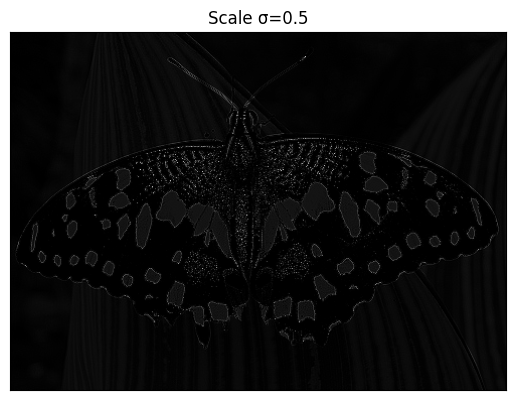

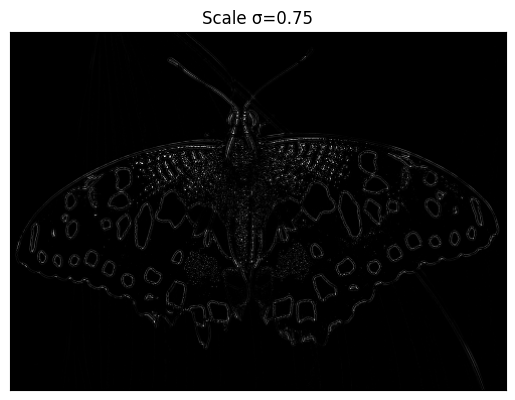

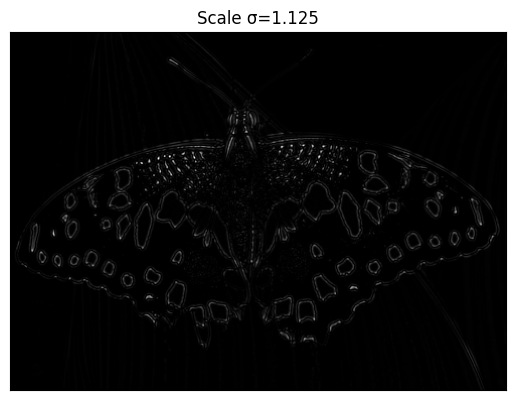

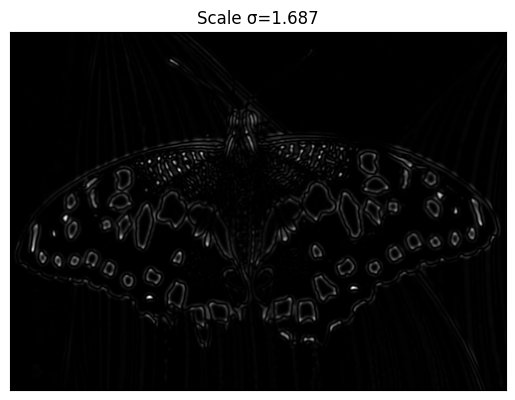

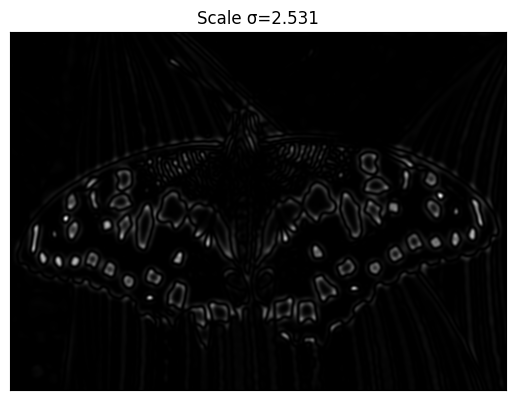

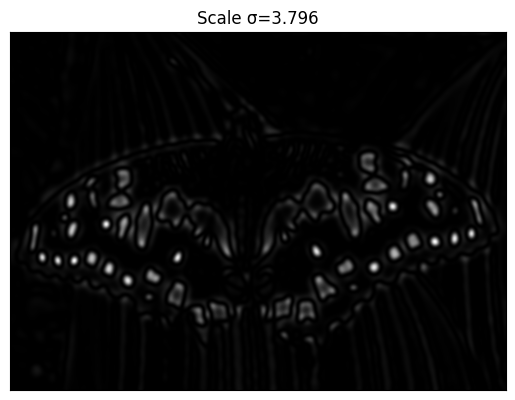

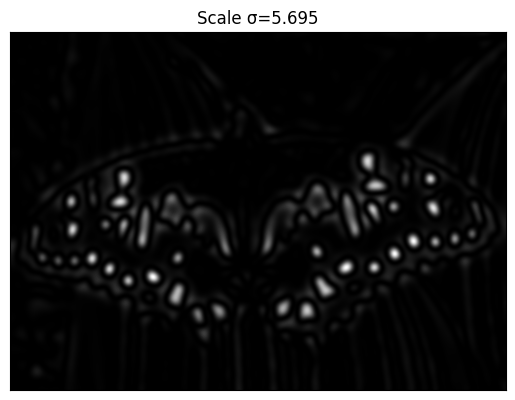

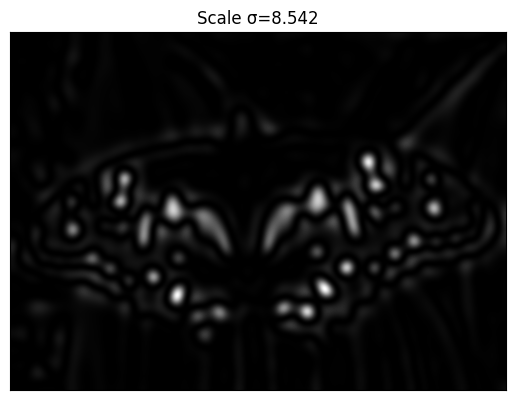

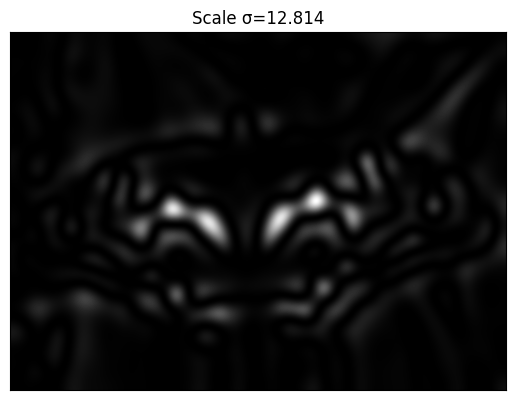

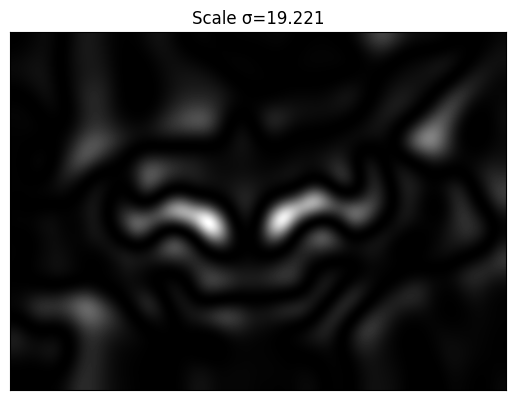

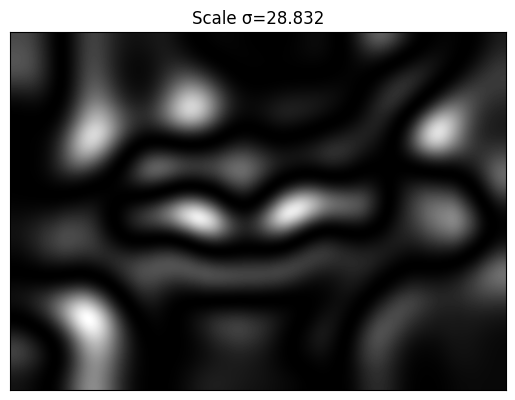

In [8]:
im=readIm(get_image('butterfly.jpg'),0)
sigmas = [0.5, 0.75, 1.125, 1.687, 2.531, 3.796, 5.695, 8.542, 12.814, 19.221, 28.832]
allLaplacianas = []

for s in sigmas:
  Laplaciana = laplaciana2D(im, s)
  Laplaciana = Laplaciana**2

  allLaplacianas.append(Laplaciana)

  Laplaciana = rangeDisplay01(Laplaciana)

  displayIm(Laplaciana, f'Scale σ={s}', 1)

# Convertir la lista de arrays en un array de NumPy
allLaplacianas = np.stack(allLaplacianas, axis=0)

Vemos que obtenemos los resultados correctos, imágenes con mucho contraste y mostrando detalles más generales según va aumentando el sigma.

A continuación para encontrar los blobs, necesitamos detectar los píxeles máximos en vecindarios de 3x3x3, para ello usamos la función maximum_filter de Scipy, la cual calcula el máximo en cada vecindario de un tamaño dado y devuelve la imagen resultante, como parámetros se le pasa un input, en nuestro caso las laplacianas anteriormente calculadas y adicionalmente le pasamos un size con el tamaño de vecindario a buscar.

El resultado lo comparamos con nuestro conjunto de laplacianas inicial para quedarnos con una matriz booleana con las coordenadas de los máximos locales. Esto se hace porque los cambios bruscos de valor de píxeles corresponden con un cambio de superficie en la imagen original, es decir con puntos de interes que es lo que buscamos detectar.

Luego indicamos un threshold para obtener solo alrededor de 1000 puntos, la idea es obtener los 1000 puntos más importantes, el threshold lo calculamos mediante prueba y error imprimiendo el número de blobs detectados para un threshold concreto.

Por último pintamos los blobs en la imagen original, para ello dibujamos circunferencias con centro en las coordenadas del máximo local y radio variable dependiendo del sigma de la laplaciana donde se encontrara el máximo local.

Blobs detectados:  994


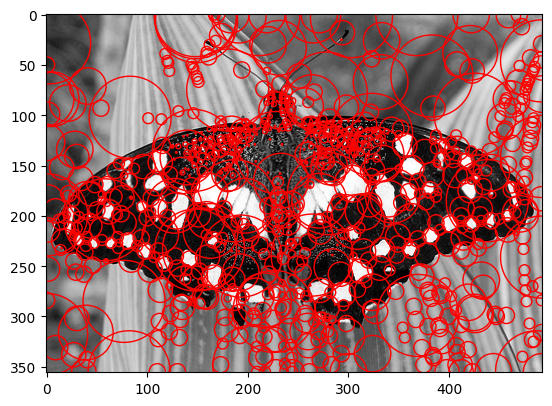

In [9]:
from scipy.ndimage import maximum_filter

threshold = 50000

# Encuentra los máximos locales en las distintas escalas
max_local = (allLaplacianas == maximum_filter(allLaplacianas, size=(3,3,3)))

# Limitamos el número de blobs detectados
max_local[allLaplacianas < threshold] = False

# Guardamos las coordenadas de los blobs detectados
coordenadas = np.argwhere(max_local)

# Vemos el número de blobs detectados que llevamos para estimar el threshold
print("Blobs detectados: ", len(coordenadas))

# Dibujamos los circulos en la imagen original
fig, ax = plt.subplots()
ax.imshow(im, cmap='gray')

for coord_ryx in coordenadas:
  r, y, x = coord_ryx
  radio = sigmas[r] * np.sqrt(2)

  circulo = plt.Circle((x, y), radio, color='r', fill=False)
  ax.add_patch(circulo)

plt.show()

En los resultados observamos como hemos detectado 994 blobs para un threshold de 50000 y los puntos detectados se corresponden tanto con zonas de cambio de textura como con la ejecución del template proporcionado por los profesores.

# <font color='blue'>**Exercise 2:** Harris Corner Detector (3 points)

<font color='blue'>Write the Python code necessary to implement the detection of the stronger 100-150 Harris points in an image. The steps to implement the Harris corner detector are the following: \


> <font color='blue'>a) Set the derivative ($\sigma_D$) and integration scales ($\sigma_I$) to 1.5 and 2.25, respectively. Other sigma values can also be employed if the student considers that it improves performance.



> <font color='blue'>b) Compute the image derivatives.

> <font color='blue'>c) Compute the three terms of the second moment matrix ($SMM$) at each pixel. To do it, apply convolution with a Gaussian mask with $\sigma_I$.

> <font color='blue'>d) Compute the Harris value at each pixel of the image (discard pixels/points close to the edges).

> <font color='blue'>e) Apply Non-Maxima Suppression by using the function `corner_peaks()` (https://scikit-image.org/docs/stable/api/skimage.feature.html#skimage.feature.corner_peaks) from the module `skimage.features`. The student must select a suitable `min_distance` (`minimal allowed distance separating peaks`), and a suitable response threshold in the Harris Map to just keep the number of keypoints we need (100-150). The output will be a list of $(x,y)$ coordinates. Extract the values in these coordinates and create a list of vectors $(x,y,value)$.

> <font color='blue'>f) Compute the main orientation for each point. This is done by smoothing both derivative images with a sufficiently large sigma ($\sigma=3$) and computing the orientation of the gradient at those points.

> <font color='blue'>d) Create a list of KeyPoints using the selected points. A KeyPoint is a vector including $(x,y,scale,orientation)$. A KeyPoint is an OpenCV's structure (`cv2.KeyPoint`), associated to each detected region,  necessary to call OpenCV feature extractor algorithms.

> <font color='blue'>e) Draw the keypoints on the image using the function `drawKeyPoints()` (https://docs.opencv.org/4.x/d4/d5d/group__features2d__draw.html#ga5d2bafe8c1c45289bc3403a40fb88920), and flags `cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS`.


El funcionamiento básico del Harris Corner Detector es el siguiente, este utiliza la variación de la intensidad en varias direcciones para determinar si un punto es una esquina, basándose en el cambio de intensidad en la dirección x e y de una región local.

Para su implementación primero declararemos una serie de funciones que realizaran los pasos intermedios del Harris Detector.

Para la función derivatives simplemente le pasamos la imagen inicial y el sigma deseado y calculamos las derivadas de la imagen en x e y usando como sigma el proporcionado.

Para la función HarrisMap le pasamos las derivadas en x e y anteriormente calculadas y el sigma deseado para esta operación y calculamos primero los términos de la Second Moment Matrix, la cual tiene el siguiente aspecto:

\begin{bmatrix}
  \sum_{w} w(x,y)\partial I_x^2 & \sum_{w} w(x,y)\partial I_x\partial I_y \\
  \sum_{w} w(x,y)\partial I_x\partial I_y & \sum_{w} w(x,y)\partial I_y^2 \\
\end{bmatrix}

Una vez tenemos la SMM podemos calcular el Harris Map de nuestra imagen inicial y devolverlo.

In [10]:
# Compute image derivatives
def derivatives(im, sigmaD):
  im = im.astype(np.float32)

  # Calculamos las máscaras gaussianas
  maskG=gaussianMask1D(sigmaD, order=0)
  maskDG=gaussianMask1D(sigmaD, order=1)

  # Derivamos la imagen en x e y
  dx = cv2.sepFilter2D(im, -1, maskDG, maskG)
  dy = cv2.sepFilter2D(im, -1, maskG, maskDG)

  return dx, dy

# Compute Harris-criterium Map
def HarrisMap(dx,dy,sigmaI):
  # Calcular los tres términos del SMM en cada pixel.
  Ix2 = cv2.GaussianBlur(dx**2, (0, 0), sigmaI)
  Iy2 = cv2.GaussianBlur(dy**2, (0, 0), sigmaI)
  Ixy = cv2.GaussianBlur(dx * dy, (0, 0), sigmaI)

  # Componentes de la matriz de Harris
  detH = Ix2 * Iy2 - Ixy**2
  traceH = Ix2 + Iy2

  # Harris response
  HMap= detH/traceH
  return HMap

Una vez tenemos el Harris Map usamos la siguiente función para limitar el número de keypoints detectados, para ello le pasamos el propio Harris Map, la distancia mínima entre dos puntos para que ambos sean keypoints y un threshold, dentro de nuestra función llamamos a la función corner_peaks de scikit-image, la cual busca máximos locales en una imagen y devuelve las coordenadas de esos máximos, que se interpretan como esquinas, para ello le pasamos los tres argumentos que se le pasan a la función NonMaximaSuppression como tal.

La idea de esto es quedarnos con las esquinas más claras y eliminar falsas esquinas no tan claras.

In [11]:
def NonMaximaSuppression(harrisMap, min_distance, threshold):
  points = corner_peaks(harrisMap, min_distance, threshold_rel=threshold)

  # Guardamos coordenadas y valores de los bordes más evidentes
  coord = points
  values = harrisMap[points[:,0], points[:,1]]

  return coord, values

Como últimas funciones tenemos orientation, que calcula la orientación de cada esquina detectada, esto se consigue haciendo un suavizado gaussiano usando un sigma grande, 3 en nuestro caso, y posteriormente calculando la orientación del gradiente en esos puntos, por último convertimos los valores de radianes a grados.

La otra función es keyPoints, que se encarga de transformar el conjunto de coordenadas y orientaciones a una lista de keyPoints, que es un tipo de dato de cv2 que luego usaremos para pintar dichos keyPoints, para crear estos keyPoints usamos la función cv2.keyPoint a la que le pasamos las coordenadas x e y, el tamaño para dibujar las circunferencias y la orientación del gradiente en dicha coordenada.

In [12]:
# compute the orientation map
def orientation(dx,dy):
  # Let's compute  orientation in degrees

  # Suavizamos las derivadas
  dx = cv2.GaussianBlur(dx, (0, 0), 3)
  dy = cv2.GaussianBlur(dy, (0, 0), 3)

  # Calculamos la orientación
  theta = np.arctan2(dy,dx) * (180 / np.pi)
  return theta

# Create the KeyPoint list from the lists of locations, orientations and scales
def keyPoints(coord,theta,size):
  keyPoint = []

  for pt in coord:
    keyPoint.append(cv2.KeyPoint(x=pt[1].astype(float), y=pt[0].astype(float), size=size, angle=theta[pt[0], pt[1]]))

  return(keyPoint)


Una vez implementadas todas las funciones mostramos los keyPoints en la imagen original, para ello seguimos los siguientes pasos:
* Cálculo de las derivadas de la imagen de entrada, para ello usamos la función derivatives y usamos un sigma de 1.5 como se nos indica.

* Cálculo del Harris Map, usamos la función HarrisMap y un sigma de 2.25 como de nuevo se nos indica, lo suyo es que este sigma tenga un valor de 1.5*sigmaD, que es el sigma usado en el paso anterior.

* Eliminamos las esquinas menos claras para quedarnos con entre 100 y 150, para ello usamos la función NonMaximaSuppression a la cual le pasamos una distancia mínima de 5, ya que entiendo que para valores menores pueden haberse detectado dos puntos que hagan referencia a la misma esquina, en cuanto a threshold lo calculo mediante prueba y error para al final quedarme con entre 100 y 150 puntos.

* Calculamos la orientación de los gradientes con orientation y los keyPoints con keyPoints, pasandole un tamaño de 15 a la hora de dibujar las circunferencias.

Y por último dibujamos los keyPoints en la imagen original con la función cv2.drawKeypoints, a la cual se le pasa:
* La imagen de entrada de la que se han obtenido los keyPoints.

* La lista de keyPoints a dibujar.

* La imagen de salida en la que se dibujarán los keyPoints.

* El color para los keyPoints.

* Los flags especificados en el guion, estos son cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG que se encarga de que los keypoints se dibujen sobre la imagen de salida sin borrar el contenido original de la imagen. Si este flag no se establece, la imagen de salida se limpia antes de dibujar los keypoints. Y cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS que indica que los keypoints deben ser dibujados con información adicional, como la escala y la orientación.

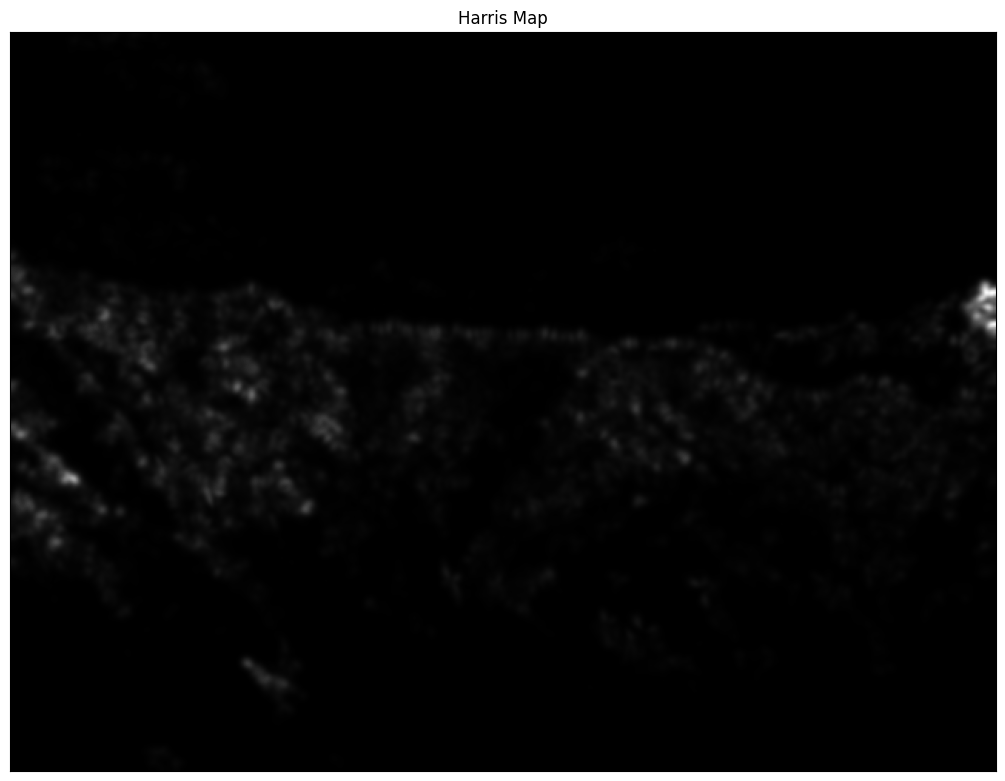



Número de bordes:136


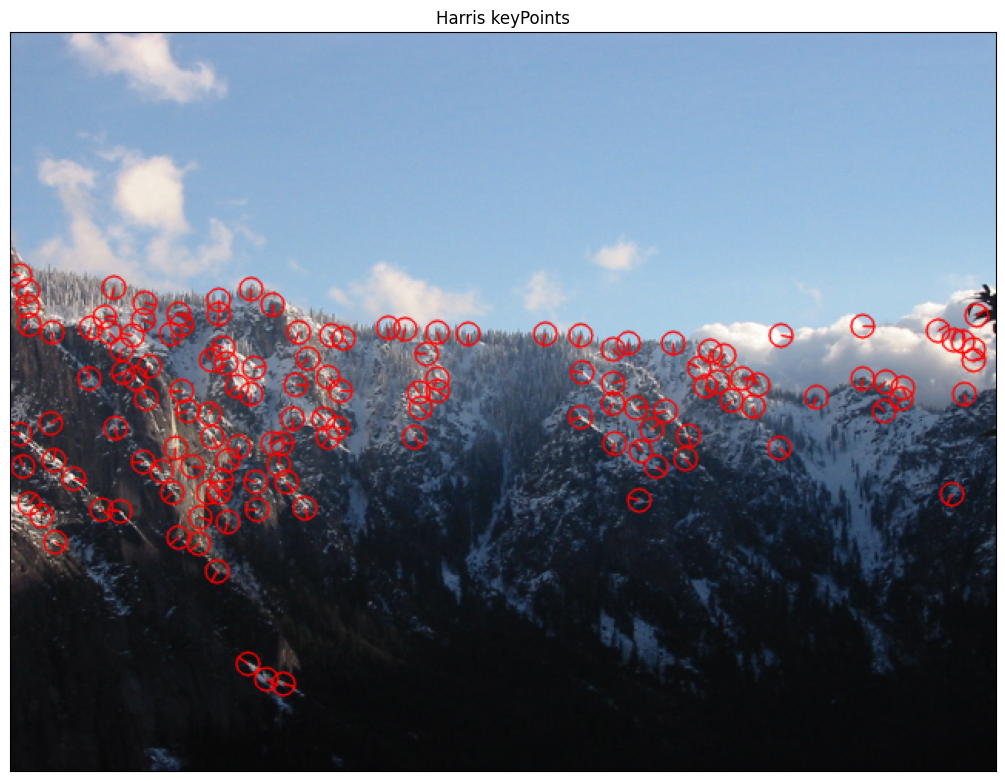

In [13]:
# Let's compute the KeyPoints-Harris and display them
from skimage.feature import corner_peaks
imgDisplay=readIm(get_image('yosemite7.jpg'),1)
img=readIm(get_image('yosemite7.jpg'),0)

# Calculamos el mapa de Harris
sigmaD = 1.5
sigmaI = 2.25

dx, dy = derivatives(img, sigmaD)

HMap = HarrisMap(dx, dy, sigmaI)

displayIm(rangeDisplay01(HMap), 'Harris Map', 2)

# Eliminamos los bordes menos evidentes
min_distance = 5
threshold = 0.08

coord, values = NonMaximaSuppression(HMap, min_distance, threshold)

print(f"\n\nNúmero de bordes:{values.size}")

# Calculamos los keyPoints
theta = orientation(dx, dy)

kP = keyPoints(coord,theta,15)

cv2.drawKeypoints(imgDisplay, kP, imgDisplay, (255,0,0), flags=cv2.DRAW_MATCHES_FLAGS_DRAW_OVER_OUTIMG+cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

displayIm(imgDisplay, 'Harris keyPoints', 2)

Vemos que el resultado es el esperado, la imagen final es similar a la del template y más allá de eso vemos que los keyPoints se corresponden con bordes y esquinas, en cuanto al número de puntos observamos que en el ejemplo proporcionado hay algunos menos aunque como estamos dentro del rango 100-150 lo dejamos así.

# <font color='blue'>**Exercise 3:** Matching keypoints between images using SIFT and Haralick descriptors (2 points)

<font color='blue'>Write the Python code necessary to compute the matching between points from two images. To do so, you have to apply the SIFT algorithm to both images in order to extract keypoints and descriptors (see https://docs.opencv.org/3.4/dc/dc3/tutorial_py_matcher.html). Then, we use the Brute-Force cross-check criterion (`cv2.BFMatcher`) and Lowe's ratio distance criterion (`knnMatch`) to compute the matches and draw the best 100 matches using the function `cv2.drawMatches`.

Para realizar este ejercicio, al igual que en el anterior creamos primero una serie de funciones auxiliares para ir realizando los pasos intermedios.

La primera función, siftPoints, se encarga de calcular los puntos clave y descriptores de una imagen dada usando el algoritmo SIFT, este algoritmo es conocido por su capacidad para encontrar puntos clave (keypoints) invariantes a la escala y la rotación. Sus pasos principales son:
* Detección de Puntos Clave (Keypoints):
  * Detección de Extremos en la Escala:
    * Identifica extremos en la escala de la diferencia de Gaussianas (DoG) para encontrar posibles ubicaciones de keypoints.
    * Utiliza una pirámide de imágenes suavizadas y diferencias de Gaussianas para simular la respuesta de un filtro Laplaciano a diferentes escalas.
  * Refinamiento de Puntos Clave:
    * Elimina los puntos que no son máximos locales en su vecindario o no cumplen con ciertos criterios de estabilidad.

* Asignación de Orientación a Keypoints:
  * Calcula la orientación dominante en cada punto clave para hacer que los keypoints sean invariantes a la rotación.
  * Utiliza un histograma ponderado de gradientes en la vecindad del punto clave.
  
* Descripción de Keypoints:
  * Construye un vector de características (descriptor) para cada punto clave basado en la orientación y las intensidades de los píxeles en su vecindario.
  * El descriptor SIFT es invariante a la escala y la rotación.

A la función le pasamos como parámetros una imagen y un número de características, a continuación creamos el objeto SIFT para hacer el posterior cálculo de descriptores pasándole como argumento el número máximo de las mejores características a retener y por último llamamos a la función detectAndCompute para calcular los keypoints y los descriptores, para ello a la función le pasamos la imagen de la que deseamos obtener dichos descriptores.

In [14]:
# this function computes KeyPoints and descriptors in an image using SIFT
def siftPoints(im,nfeatures=5000):
  sift = cv2.SIFT_create(nfeatures)

  kp, ds = sift.detectAndCompute(im, None)

  return kp,ds

La función showKP muestra la imagen que se le pase con los keypoints que se le pase, para ello al igual que en el anterior ejercicio hago uso de la función cv2.drawKeypoints.

La función showMatches muestra los matches entre keypoints de dos imágenes pasadas, adicionalmente a la función también se le pasan los keypoints de ambas imágenes, el array de matches y el número máximo de matches a mostrar. Para mostrarlos se usa la función cv2.drawMatches a la cual se le pasan los parámetros mencionados.

Por último la función matching se encarga de calcular los matches entre los keypoints de dos imágenes usando sus descriptores, dependiendo del Flag que se le pase a la función se usará un método u otro.

El primer método consiste en aplicar BruteForce+CrossCheck, para ello inicializamos un objeto cv2.BFMatcher con crossCheck a true y calculamos los matches con el método match, al cual le pasamos los descriptores de ambas imágenes, por último ordenamos los matches por distancia y los devolvemos.

El segundo método consiste en aplicar el criterio de Lowe's ratio distance, por lo que inicializamos otro objeto BFMatcher aunque sin especificar ningún argumento esta vez y llamo a continuación al método knnMatch para calcular los matches, de nuevo paso los descriptores, así como un valor k para especificar los k mejores matches, en nuestro caso lo establecemos a 2, lo que significa que para cada descriptor en el conjunto de consulta, la función buscará los dos vecinos más cercanos en el conjunto de entrenamiento. Luego, se aplica la relación de Lowe's para filtrar los buenos matches basándose en las distancias entre estos vecinos más cercanos. A mayor valor k, más matches se obtienen, pero también es más probable obtener matches incorrector, por ello elijo un valor bajo como 2.

Por último utilizamos la relación de Lowe para filtrar los buenos matches, los ordenamos al igual que usando el primer método y los devolvemos, al filtrar los buenos matches usamos una distancia de radio de 0.75, ya que con esta conseguimos eliminar alrededor del 90% de los matches incorrectos mientras que solo descartamos sobre un 5% de los matches correctos, como se puede ver en el siguiente paper: https://www.cs.ubc.ca/~lowe/papers/ijcv04.pdf#page=20

En cuanto a como funcionan por dentro ambos métodos usados, su funcionamiento es el siguiente:
* BruteForce+CrossCheck: La parte "BruteForce" se refiere al enfoque de búsqueda directa y simple que se utiliza para comparar descriptores entre dos conjuntos de keypoints, cada descriptor en el conjunto de consulta se compara con todos los descriptores en el conjunto de entrenamiento. La parte "CrossCheck" implica un filtrado adicional para mejorar la precisión de las coincidencias. Después de realizar la búsqueda bruta, se verifica si una coincidencia es recíproca, si un descriptor A en el conjunto de consulta tiene al descriptor B en el conjunto de entrenamiento como el mejor match, y B también tiene A como el mejor match, entonces la coincidencia es considerada como válida.

* Lowe's ratio distance: Se realiza una búsqueda de vecinos más cercanos para cada descriptor en el conjunto de consulta. Esto significa que para cada descriptor en el conjunto de consulta, se encuentran los k descriptores más cercanos en el conjunto de entrenamiento. Para cada par de vecinos más cercanos encontrados durante la búsqueda se calcula el cociente de distancias entre el descriptor más cercano y el segundo descriptor más cercano. Si este es menor que un umbral predefinido, se considera que la coincidencia es buena.

In [15]:
# This function display the KeyPoints of an image
def showKP(im,kp,title):
  cv2.drawKeypoints(im, kp, im, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
  displayIm(im,title,1)

# This function display the matches between two images
def showMatches(im1,kp1,im2,kp2,matches, N, title='Matches'):
  imBF = cv2.drawMatches(im1, kp1, im2, kp2, matches[:N], None)
  displayIm(imBF,title,2)

#This function compute matches between descriptors of two images
def matching(ds1,ds2,FlagMode='BF'):
  if FlagMode=='BF':
    bf = cv2.BFMatcher(crossCheck=True)
    matches = bf.match(ds1, ds2)

    # Ordenamos los matches según la distancia para luego elegir los 100 mejores
    matches = sorted(matches, key = lambda x:x.distance)

    return matches
  elif FlagMode=='KNN':
    bf = cv2.BFMatcher()
    matches = bf.knnMatch(ds1, ds2, k=2)

    # Aplicamos ratio test
    good = []
    for m,n in matches:
        if m.distance < 0.75*n.distance:
            good.append(m)

    # Ordenamos los matches según la distancia para luego elegir los 100 mejores
    good = sorted(good, key = lambda x:x.distance)

    return good
  else:
    return print('Error in Matching mode')


Una vez tenemos todas las funciones auxiliares pasamos a dibujar los matches de las imágenes dadas, los pasos son sencillos:
* Primero obtenemos la lista de descriptores y keypoints con siftPoints.

* Luego calculamos los matches de los descriptores de ambas imágenes, primero usando BF.

* Por último dibujamos el resultado, mostramos solo los 100 mejores matches como se nos indica.

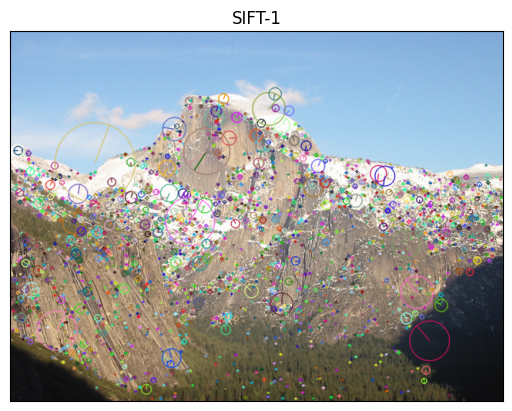

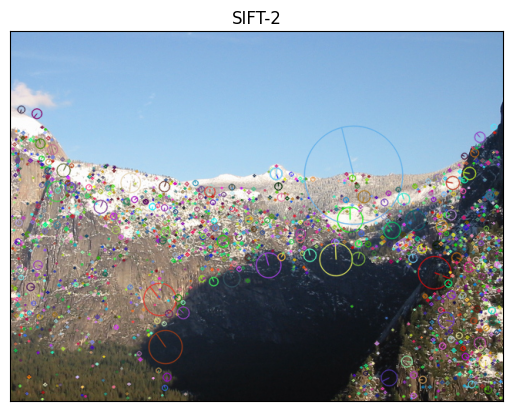

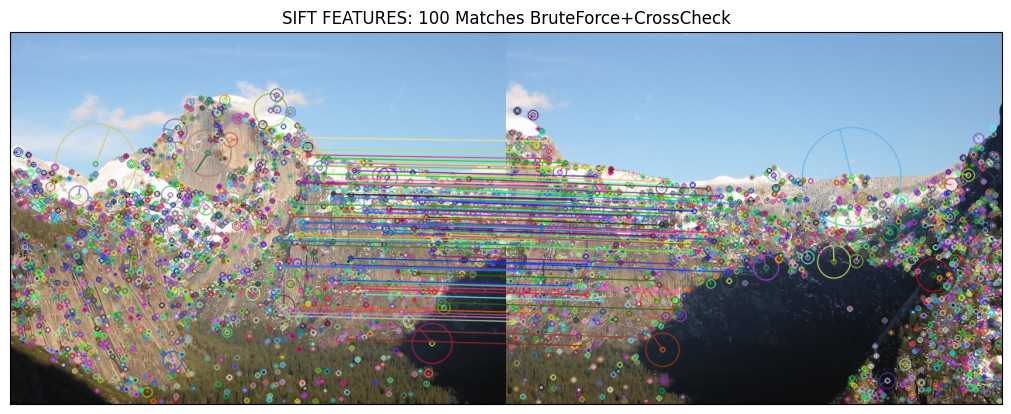

In [16]:
img1=readIm(get_image('yosemite2.jpg'),1)
im1=cv2.cvtColor(img1,cv2.COLOR_RGB2GRAY)
img2=readIm(get_image('yosemite3.jpg'),1)
im2=cv2.cvtColor(img2,cv2.COLOR_RGB2GRAY)

# Obtenemos los keyPoints y descriptores de las imágenes
kp1, ds1 = siftPoints(im1)
kp2, ds2 = siftPoints(im2)

showKP(img1, kp1, 'SIFT-1')
showKP(img2, kp2, 'SIFT-2')

# Emparejamos los descriptores con BF+CrossCheck
matches1 = matching(ds1, ds2, 'BF')
showMatches(img1, kp1, img2, kp2, matches1, 100, title='SIFT FEATURES: 100 Matches BruteForce+CrossCheck')

En los resultados primero imprimimos las imágenes por separado con los keypoints detectados, observamos que hay más que en el ejemplo dado, esto puede deberse a la inicialización del objeto SIFT, ya que yo lo inicializaba a 5000 features, no obstante vemos que los keypoints que si hay en el ejemplo son iguales que los que yo he detectado.

Por último imprimimos ya el resultado de aplicar los matches de ambas imágenes, podemos observar que estos son correctos, al menos en su mayoría, y los keypoints de A se corresponden con los de B. Por otro lado el resultado también es similar al del template.

A continuación hacemos lo mismo pero con usando el método KNN.

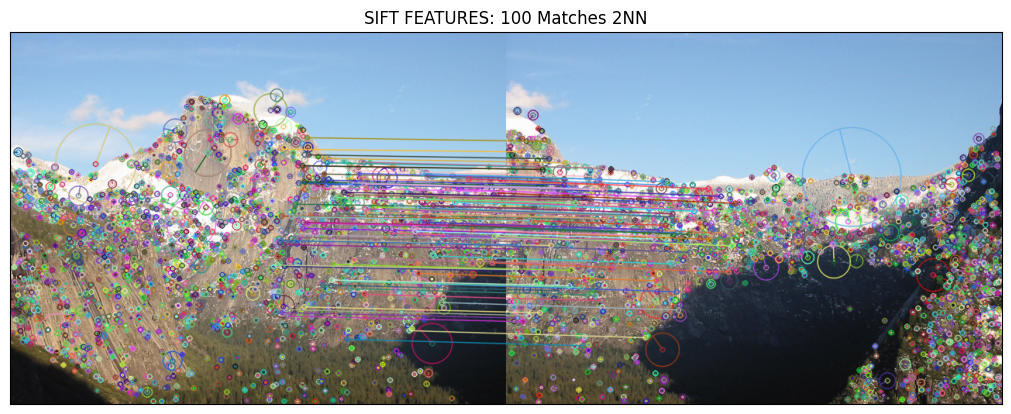

In [ ]:
# Emparejamos los descriptores con Radio Test
matches2 = matching(ds1, ds2, 'KNN')
showMatches(img1, kp1, img2, kp2, matches2, 100, title='SIFT FEATURES: 100 Matches 2NN')

De nuevo vemos que el resultado parece correcto, los keypoints conectados se corresponden los de una imagen con los de la otra.

<font color='blue'>Now, we have to perform exactly the same operation, but employing Haralick features. To do so, we are going to create a small window ($7\times7$ pixels) centered around the SIFT keypoint detected, and we are going to use `mahotas` library to compute those texture-based descriptors.

Ahora en vez de usar SIFT para obtener los descriptores de los keypoints usaremos Haralick, que es similar a SIFT solo que este extrae texturas de una ventana alrededor del punto indicado en la imagen, tales como el contraste o la energía, en total son 13 descriptores.

In [ ]:
!pip install mahotas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.4/5.4 MB 12.2 MB/s eta 0:00:00


A continuación aplicamos Haralick a los distintos keypoints de las imágenes previamente calculados, calculamos el tamaño de ventana manualmente y pasamos dicha ventana como parámetro a Haralick, que nos devuelve las features en ese keypoint, es decir, los descriptores.

In [ ]:
import mahotas

window_size = 3 # Valores a izq, der, arriba y abajo del kp que se tienen en cuenta

ds_1 = np.empty((0,13))
ds_2 = np.empty((0,13))

# Descriptores de la imagen 1
for kp in kp1:
  # Obtenemos las coordenadas del punto clave
  x, y = kp.pt
  x, y = int(x), int(y)

  # Extraer la ventana centrada alrededor del punto clave
  coord_y1 = y - window_size
  coord_y2 = y + window_size+1
  coord_x1 = x - window_size
  coord_x2 = x + window_size+1

  if coord_y1 < 0: coord_y1 = 0
  if coord_y2 > im1.shape[0]: coord_y2 = im1.shape[0]
  if coord_x1 < 0: coord_x1 = 0
  if coord_x2 > im1.shape[1]: coord_x2 = im1.shape[1]

  window = im1[coord_y1:coord_y2, coord_x1:coord_x2]

  # Calcular los descriptores de textura con Mahotas
  features = mahotas.features.haralick(window).mean(axis=0)
  ds_1 = np.vstack((ds_1, features))

# Descriptores de la imagen 2
for kp in kp2:
  # Obtenemos las coordenadas del punto clave
  x, y = kp.pt
  x, y = int(x), int(y)

  # Extraer la ventana centrada alrededor del punto clave
  coord_y1 = y - window_size
  coord_y2 = y + window_size+1
  coord_x1 = x - window_size
  coord_x2 = x + window_size+1

  if coord_y1 < 0: coord_y1 = 0
  if coord_y2 > im2.shape[0]: coord_y2 = im2.shape[0]
  if coord_x1 < 0: coord_x1 = 0
  if coord_x2 > im2.shape[1]: coord_x2 = im2.shape[1]

  window = im2[coord_y1:coord_y2, coord_x1:coord_x2]

  # Calcular los descriptores de textura con Mahotas
  features = mahotas.features.haralick(window).mean(axis=0)
  ds_2 = np.vstack((ds_2, features))


Una vez tenemos los descriptores es igual que antes, llamamos a matching e imprimimos los resultados.

In [ ]:
ds_1 = ds_1.astype(np.float32)
ds_2 = ds_2.astype(np.float32)

# Emparejamos los descriptores con BF+CrossCheck
matches1 = matching(ds_1, ds_2, 'BF')
showMatches(img1, kp1, img2, kp2, matches1, 100, title='HARALICK FEATURES: 100 Matches BruteForce+CrossCheck')

# Emparejamos los descriptores con Radio Test
matches2 = matching(ds_1, ds_2, 'KNN')
showMatches(img1, kp1, img2, kp2, matches2, 100, title='HARALICK FEATURES: 100 Matches 2NN')

Output hidden; open in https://colab.research.google.com to view.

Estos resultados son mucho peores que en el caso de usar los descriptores de SIFT, probablemente por el número de features que se obtienen de cada uno, al obtener solo 13 usando Haralick a la hora de hacer los matches puede dar lugar a confusiones de keypoints con las mismas features. En la imagen vemos que los puntos correlacionados son en su mayoría incorrectos.

<font color='blue'> Which feature descriptor seems to be more suitable for keypoint matching? Why?

SIFT, ya que este nos da un descriptor con 128 valores, que a la hora de hacer los matches entre keypoints es bastante más discriminatorio que los 13 valores que nos proporciona el descriptor de Haralick, aparte de que es menos sensible a cambios de luz o rotación en las imágenes.

# <font color='blue'>**Exercise 4:** Image Stitching using Homographies (3 points)

<font color='blue'>Now we are going to compute homographies between images, and use them to build a mosaic/panorama. To calculate the homography between two images, call the function `cv2.findHomography()`, which takes as input the lists of KeyPoints and the matches found between them. Use RANSAC to perform a robust estimation.

La siguiente función calcula la homografía entre dos imágenes, para ello le pasamos puntos clave de ambas imágenes previamente calculados y una lista de matches entre esos puntos clave. Lo primero que hace la función es ordenar esos matches según la distancia por si no lo estuvieran, luego obtiene los keypoints correspondientes a dichos matches y se llama a la función cv2.findHomography que calcula la homografía como tal pasándole dichos keypoints, un algoritmo para realizar la búsquedad, en nuestro caso usaremos RANSAC, y un error para RANSAC, para la hora de que este seleccione que valores son outliers y cuales no. Por último devolvemos la homografía calculada.

El funcionamiento interno del algoritmo RANSAC es el siguiente:
1. Selección Aleatoria de Muestras: Se selecciona aleatoriamente un subconjunto de puntos del conjunto de datos original y se ajusta el modelo al subconjunto seleccionado.

2. Evaluación de Inliers: Se evalúa qué tan bien el modelo ajustado se ajusta al resto de los puntos del conjunto de datos y se etiquetan como "inliers" aquellos puntos que están suficientemente cerca del modelo ajustado.

3. Criterio de Consenso: Se establece un criterio de consenso, que puede ser el número total de inliers o alguna medida de la calidad del ajuste del modelo.

4. Iteración: Se repiten los pasos anteriores un número especificado de veces o hasta que se alcanza un criterio de convergencia.

5. Mejor Modelo: Se selecciona el modelo que tiene el mayor número de inliers o satisface mejor el criterio de consenso.

6. Refinamiento del Modelo (Opcional): Se puede refinar el modelo utilizando todos los inliers identificados.

In [ ]:
# this function computes a homography
def homography(kp1,kp2,matches, Ransac_Error,MIN_MATCH_COUNT=20):
  # the order is important
  matches = sorted(matches, key = lambda x:x.distance)

  if len(matches)>MIN_MATCH_COUNT:
    # Obtener los puntos correspondientes de los emparejamientos
    src_pts = np.float32([kp1[m.queryIdx].pt for m in matches])
    dst_pts = np.float32([kp2[m.trainIdx].pt for m in matches])

    H, _ = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, Ransac_Error)
  else:
     print('Error - very few matches')
  return H

<font color='blue'>To compose the mosaic we need to provide the following information:

> <font color='blue'>a) Maximum size of the canvas according to the number of images to be stitched and their dimensions.

> <font color='blue'>b) The central image that will give the axes to the mosaic.

> <font color='blue'>c) The order of each image with respect to the central one (i.e., we know the position of each image in the burst of images taken).

> <font color='blue'>d) The homography to copy the central image into the canvas.

<font color='blue'>Now, once all the aforementioned decisions have been made, we need to proceed as follows:
> <font color='blue'>a) Read the images from left to right.

> <font color='blue'>b) Set one central image as the reference to create the panorama. This one will provide the axes to the canvas.

> <font color='blue'>c) Compute the homography between each two consecutive images in your list.

> <font color='blue'>d) Set the canvas and the reference homography.

> <font color='blue'>e) Compute the homography between each image and the canvas.

> <font color='blue'>f) Use the computed homographies to transport the images to the canvas. Use the function `cv2. warpPerspective()`.

> <font color='blue'>g) Remove the black regions from the canvas to improve quality.



La primera función se encarga de ir calculando las homografias de imágenes consecutivas dada una lista de imágenes, para ello calcula los keypoints y matches de estas imágenes consecutivas con las funciones usadas en el ejercicio anterior y por último calcula la homografía entre ambas imágenes usando la función creada justo antes, homography. A la hora de calcular los matches usamos el método KNN, más robusto que BF y para calcular las homografías usamos un error para RANSAC de 5.0

La siguiente función se encarga de calcular las homografías de las imágenes con respecto al canvas, le pasamos la lista de homografías y el índice de la que será la imágen central en el canvas, primero vamos recalculando las homografías del centro a la izquierda, luego recalculamos del centro hacia la derecha, en este lado aparte de ir multiplicando las homografías, le damos la vuelta, esto para que al final en el mosaico estas imágenes estén tumbadas de lado contrario a las de la izquierda, es decir, todas apuntando al centro.

La última función que viene ya hecha sirve para calcular la homografía centra respecto al canvas, la idea es situarla en el centro del mismo, por eso las divisiones entre 2.

In [ ]:
# this function computes the homographies between each two consecutive images
def computeLocalHomographies(images,method='KNN', Ransac_Error=5.0):
  H = []

  for i in range(len(images)-1):
    # Obtenemos los keyPoints y descriptores de las imágenes
    kp1, ds1 = siftPoints(images[i])
    kp2, ds2 = siftPoints(images[i+1])

    # Emparejamos los descriptores
    matches = matching(ds1, ds2, method)

    # Creamos la homografía
    H.append(homography(kp1, kp2, matches, Ransac_Error))

  return H

# this function computes the homography from each image to the canvas
# idx in this case is the central image
def mosaicHomographies(H,idx):
  # Iterar sobre todas las imágenes y calcular las homografías en relación con la imagen central
  # Parte izquierda
  for i in range(idx-1, 0, -1):
    H[i-1] = np.dot(H[i], H[i-1])

  # Parte central
  H[idx] = np.linalg.inv(H[idx])

  # Parte derecha
  for i in range(idx+1, len(H), 1):
    H[i] = np.dot(np.linalg.inv(H[i]), H[i-1])

  return H

# this function fixes the homography from the central image to the canvas
def axesHomography(sizeim,sizecanvas):
  H=np.eye(3)
  H[0,2]=sizecanvas[1]//2-sizeim[1]//2
  H[1,2]=sizecanvas[0]//2-sizeim[0]//2
  return H

Las siguientes funciones son para generar y msotrar el canvas, la primera calcula las dimensiones del mismo en base al tamaño de las imágenes y al número de las mismas que queremos añadir.

La otra función que viene ya creada sirve para a la hora de mostrar el mosaico se eliminen los bordes negros y así se vea el mosaico lo mejor posible.

In [ ]:
# Auxiliary functions

# this function defines and return the canvas
def setCanvas(row,col,flagColor,nim=2):
  rows = row*nim
  cols = col*nim

  if flagColor:
    return np.zeros((rows, cols, 3), np.uint8)
  else:
    return np.zeros((rows, cols), np.uint8)

# This function removes the redundant pixels from the canvas
def blackOut(img, offset=0):
  if len(img.shape)==3:
    im =cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
    mask = np.array((im > 0), np.uint8)
    x,y,w,h=cv2.boundingRect(mask)
    return img[y+offset:y+h-offset,x+offset:x+w-offset,:]
  else:
    mask = np.array((img > 0), np.uint8)
    x,y,w,h=cv2.boundingRect(mask)
    return img[y+offset:y+h-offset,x+offset:x+w-offset]



Por último tenemos la función que se encarga de componer el mosaico, antes de explicar los detalles de la misma hablaré acerca de una función auxiliar que luego uso en composeMosaic, esta es reorder_indices, la cual lo que hace es dados una lista y un índice, devuelve una lista de índices ordenados según su distancia al índice dado, siendo este índice dado el último elemento de la lista de índices. Esto lo hago porque a la hora de pegar las imágenes en el canvas hay que hacerlo de los extremos al centro para que el mosaico quede bien.

En cuanto a la función composeMosaic, le pasamos la lista de imágenes para crear el mosaico, el canvas donde pegar las imágenes, las homografías de las imágenes consecutivas, el índice de la imagen central y la homografía central. Primero calculamos el orden de índices y luego vamos pegando las imágenes en el canvas desde los extremos al centro usando la función cv2.warpPerspective, esta función se utiliza para aplicar transformaciones de perspectiva a imágenes, sus argumentos son:
* Una imagen de entrada que es la que se transforma.

* La homografía que es la que tiene la información de la transformación de perspectiva (para las imágenes distintas de la central multiplicamos por la homografía central para recalcular sus homografías respecto a esta).

* El tamaño del resultado deseado, que es el mismo tamaño que tenía la imagen original.

* La imagen donde se almacena el resultado, en nuestro caso el canvas que se va actualizando con cada imagen.

* El modo para los bordes, en nuestro caso especificamos que sean transparentes.

* Otros flags, nosotros usamos cv2.INTER_CUBIC, que representa el método de interpolación cúbica. Cuando redimensionas una imagen, puedes encontrarte con espacios vacíos o áreas donde los píxeles no coinciden perfectamente. La interpolación cúbica ayuda a suavizar estas transiciones y proporciona resultados más suaves y continuos en comparación con la interpolación lineal. Sin embargo, puede ser más costoso computacionalmente.

In [ ]:
# Esta función calcula el orden de índices de una lista según su distancia al
# índice idx
def reorder_indices(lst, idx):
  # Calcular la distancia de cada índice a idx
  distances = [(i, abs(i - idx)) for i in range(len(lst))]

  # Ordenar los índices según la distancia a idx (de mayor a menor)
  sorted_indices = sorted(distances, key=lambda x: x[1], reverse=True)

  # Extraer los índices ordenados
  reordered_indices = [index for index, _ in sorted_indices]

  return reordered_indices

# this function composes the mosaic
def composeMosaic(images,canvas,H,idxc,H0):
  rows=canvas.shape[0]
  cols=canvas.shape[1]

  indices = reorder_indices(images, idxc)

  for i in indices[:-1]:
    i2 = i
    if i > idxc: i2 = i-1

    canvas=cv2.warpPerspective(images[i], np.dot(H0, H[i2]), (cols, rows), dst=canvas, flags=cv2.INTER_CUBIC, borderMode = cv2.BORDER_TRANSPARENT)
    #displayIm(blackOut(canvas),'',2)

  canvas=cv2.warpPerspective(images[idxc], H0, (cols, rows), dst=canvas, flags=cv2.INTER_CUBIC, borderMode = cv2.BORDER_TRANSPARENT)

  return canvas

Por último usamos todas estas funciones creadas para generar el mosaico, los pasos son los siguientes:
* Primero calculamos las homografías entre imágenes consecutivas.

* Luego calculamos las homografrías de esas imágenes respecto al canvas, como imagen centra en este caso elijo la sexta imagen, esta decisión la tomo a ojo imaginando como quedaría el mosaico final viendo las imágenes por separado y llegando a la conclusión de que es la sexta imagen la que tomará la posición más central en ese mosaico imaginado. Esta imagen central no tiene que ser necesariamente igual a total_img/2 como ha sido este caso, ya que puede haber algunas imágenes que abarquen paisajes más grandes y otras que abarquen paisajes más pequeños y a la hora de generar el mosaico por ejemplo 3 imágenes pequeñas se correspondan con una grande, haciendo que img_central = total_img/2 ya no valga.

* Después calculamos el canvas y la homografía central en función del tamaño del canvas y la imagen central.

* Por último componemos el mosaico y lo mostramos usando blackOut para eliminar los bordes negros.

In [ ]:
images=[]
#Mosaic construction: Left-Right camera motion

PREFIX='IMG_20211030_1104'
DIR=''
nameImages=['10_S.jpg','13_S.jpg','15_S.jpg','17_S.jpg','18_S.jpg','20_S.jpg',
            '21_S.jpg', '25_S.jpg','26_S.jpg', '28_S.jpg','31_S.jpg','33_S.jpg',
            '34_S.jpg','36_S.jpg']
idx = 5

for item in nameImages:
  images.append(readIm(get_image(PREFIX+item),flagColor=1))

H=computeLocalHomographies(images)
H=mosaicHomographies(H, idx)
canvas=setCanvas(images[idx].shape[0], images[idx].shape[1], True, len(images))
H0=axesHomography(images[idx].shape, canvas.shape)
mosaic= composeMosaic(images, canvas, H, idx, H0)
displayIm(blackOut(mosaic),'Mosaico',8)

Output hidden; open in https://colab.research.google.com to view.

El resultado final es el correcto, vemos que tomamos una decisión acertada al elegir la sexta imagen como la central, podemos también observar que todas las imágenes están bien unidas con sus contiguas, por lo que los matches han sido seleccionados correctamente y las homografías están bien calculadas. También vemos que este mosaico se corresponde con el mosaico del ejemplo.